In [1]:

import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import jax
import jax.scipy.special as sci
import jax.scipy.integrate as integrate
import jax.numpy as jnp
from jax import grad
import numpy as np
import sys

import scienceplots

plt.style.use("science")
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 16
})


fname = "../runs/AdjointTestProblem.nc"

In [2]:


data = Dataset(fname)
print(data)
Vars = data.groups
Grid = jnp.array(np.array(data.groups["Grid"].variables["CellBoundaries"]))
t = jnp.array(np.array(data.variables["t"]))
x = jnp.array(np.array(data.variables["x"]))
u = jnp.array(np.array(Vars["Var0"].variables["u"]))
data.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): t(21), x(301)
    variables(dimensions): float64 t(t), float64 x(x), float64 nVariables(), float64 GFn(), float64 np(), float64 np_boundary()
    groups: Grid, Var0, G_p, G_boundary


In [3]:

# q = jnp.array(np.array(Vars["Var0"].variables["q"]))

# G0 = np.array(data.variables["G0"])
# print(G0)
# p0 = np.array(data.variables["p0"])
# print(p0)

# data.close()


In [4]:
u0 = 0.3#u[0,:]

T_s = 50
D = 2.0
c= 0.3

# d = np.sqrt(c)


# S = d*np.sqrt(np.pi)*( d/np.sqrt(np.pi)*( np.exp(-(x-b)**2/c) - np.exp(-(1-b)**2/c) ) + (1 - b)*sci.erf((1-b)/d)
#                      + (1-x)*sci.erf(b/d) - (x-b)*sci.erf((x-b)/d) )

# uan = (u0**(1+a) + T_s/D*(1+a)*S)**(1/(1+a))
def uan(x,c,a,u1):
    b = 0.02
    d = 50.0

    exponent = -0.5

    y = (x - c)/jnp.sqrt(b)
    G = (b*d/(4*a)) * ( jnp.exp( -(1-c)**2/b ) - jnp.exp( -y**2 ) ) + (d*jnp.sqrt( b*jnp.pi )/(4*a)) * ( (c-1)*sci.erf( (c-1)/jnp.sqrt(b) ) + (1-x)*sci.erf(c/jnp.sqrt(b)) - (x-c)*sci.erf(y) )
    u2 = u1**(1+exponent) + 2*(1+exponent)*G
    return u2**(1.0/(1+exponent))

g = lambda c, D, u0 : integrate.trapezoid(0.5*uan(x,c,D, u0)**2,x)

gradp = jax.grad(g, argnums=(0,1,2))
grad_c, grad_kappa, grad_u0 = gradp(c, D, u0)



$\frac{\partial u}{\partial t} - \kappa \frac{\partial^2 u}{\partial x^2} = A \exp{(-(x-c)^2/b)}$

/tmp/ipykernel_39269/4281011695.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


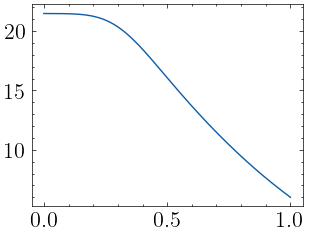

In [5]:
fig,ax = plt.subplots()
ax.plot(x,u[-1,:])
ax.legend()
plt.ioff()

In [6]:
import toml
import time

config_file = "../Config/AdjointTestProblem.conf"

manta_file = "../MaNTA"
def run_manta( config_file ):
    code = os.system( manta_file + " " + config_file + " >/dev/null" )
    if( code != 0 ):
        print("Failed to run test simulation with configuration in " + config_file)
        sys.exit(code)


cs = jnp.linspace(0.1,0.9,10)
D = 2.0
u0 = 0.3
G_comp = []
g_c_an = []
g_kappa_an = []
g_u0_an = []
fig2,ax2 = plt.subplots(2,3,sharex='col')
fig,ax=plt.subplots(1,4)
for c in list(cs):
    config = toml.load(config_file)
    config["AdjointTestProblem"]["SourceCentre"] = float(c)
    config["AdjointTestProblem"]["kappa"] = float(D)
    config["AutodiffTransportSystem"]["InitialHeights"] = [float(u0)]
    config["AutodiffTransportSystem"]["uR"] = [float(u0)]
    
    
    with open(config_file,"w") as f:
        s = toml.dump(config,f)
    run_manta(config_file)
    data = Dataset("AdjointTestProblem.nc","r")
    p2 = np.array(data.groups["G_boundary"].variables["p0"])
    p1 = np.array(data.groups["G_p"].variables["p1"])
    p0 = np.array(data.groups["G_p"].variables["p0"])
    G0 = np.array(data.variables["GFn"])
    data.close()
    ln, = ax2[0,0].plot(c,p0,'rx',linewidth=2.0)
    ax[0].plot(c,p0,'rx')
    ax[1].plot(c,p1,"rx")
    ax[2].plot(c,p2,"rx")
    ax[3].plot(c,G0,'rx')
   
ln.set_label(r"$\frac{dG}{dc}$ (adjoint)")
cs = jnp.linspace(np.min(cs),np.max(cs),50)
for c in cs:
    grad_c, grad_kappa, grad_u0 = gradp(c, D, u0)
    
    g_c_an.append(grad_c)
    g_kappa_an.append(grad_kappa)
    g_u0_an.append(grad_u0)
    G_comp.append(g(c,D, u0))

ax[0].plot(cs,g_c_an,'k')
ax2[0,0].plot(cs,g_c_an,'k',label=r"$\frac{dG}{dc}$ (analytic)",linewidth=2.0,zorder=-1)
ax[1].plot(cs,g_kappa_an,'k')
ax[2].plot(cs,g_u0_an,'k')

ax[3].plot(cs,G_comp,'k',label="analytic")

ycolor = 'b'

ax3 = ax2[1,0]
ax3.plot(cs,G_comp,label=r"$G(c)$",color=ycolor,linewidth=2.0)
# ax3.set_ylabel('G',color=ycolor)
# ax3.tick_params(axis='y', labelcolor=ycolor)

ax[0].set_title(r"$dG/dc$")
ax[1].set_title(r"$dG/d\kappa$")
ax[2].set_title(r"$dG/du_0$")
ax[3].set_title(r"$G = \int u^2/2 dx$")

ax[0].set_xlabel("c")
ax[1].set_xlabel("c")
ax[2].set_xlabel("c")
ax[3].set_xlabel("c")
ax2[1,0].set_xlabel("c")

ax[3].legend()

for a in ax:
    a.set_box_aspect(1)

fig.set_figwidth(15)






INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO:

In [7]:
c = 0.3
Ds = jnp.linspace(2.0,10.0,10)
u0 = 0.3
G_comp = []
g_c_an = []
g_kappa_an = []
g_u0_an = []
fig,ax=plt.subplots(1,4)
for D in list(Ds):
    config = toml.load(config_file)
    config["AdjointTestProblem"]["SourceCentre"] = float(c)
    config["AdjointTestProblem"]["kappa"] = float(D)
    config["AutodiffTransportSystem"]["InitialHeights"] = [float(u0)]
    config["AutodiffTransportSystem"]["uR"] = [float(u0)]
    
    with open(config_file,"w") as f:
        s = toml.dump(config,f)
    run_manta(config_file)
    data = Dataset("AdjointTestProblem.nc","r")
    p2 = np.array(data.groups["G_boundary"].variables["p0"])
    p1 = np.array(data.groups["G_p"].variables["p1"])
    p0 = np.array(data.groups["G_p"].variables["p0"])
    G0 = np.array(data.variables["GFn"])
    data.close()

    ax[0].plot(D,p0,'rx')
    ax[1].plot(D,p1,"rx")
    ln, = ax2[0,1].plot(D,p1,"rx",linewidth=2.0)
    ax[2].plot(D,p2,"rx")
    ax[3].plot(D,G0,'rx')

ln.set_label(r"$\frac{dG}{dD}$ (adjoint)")

Ds = jnp.linspace(2.0,10.0,50)
for D in Ds:
    grad_c, grad_kappa, grad_u0 = gradp(c, D, u0)
    
    g_c_an.append(grad_c)
    g_kappa_an.append(grad_kappa)
    g_u0_an.append(grad_u0)
    G_comp.append(g(c,D,u0))

ax[0].plot(Ds,g_c_an,'k')
ax[1].plot(Ds,g_kappa_an,'k')
ax2[0,1].plot(Ds,g_kappa_an,'k',label=r"$\frac{dG}{dD}$ (analytic)",linewidth=2.0,zorder=-1)
ax[2].plot(Ds,g_u0_an,'k')
ax[3].plot(Ds,G_comp,'k')

ax3 = ax2[1,1]
ax3.plot(Ds,G_comp,label=r"$G(D)$",color=ycolor,linewidth=2.0)
# ax3.set_ylabel('G',color=ycolor)
# ax3.tick_params(axis='y', labelcolor=ycolor)

ax[0].set_title(r"$dG/dc$")
ax[1].set_title(r"$dG/d\kappa$")
ax[2].set_title(r"$dG/du_0$")
ax[3].set_title(r"$G = \int u^2/2 dx$")

ax[0].set_xlabel("D")
ax[1].set_xlabel("D")
ax[2].set_xlabel("D")
ax[3].set_xlabel("D")
ax2[1,1].set_xlabel("D")

ax[3].legend()

for a in ax:
    a.set_box_aspect(1)

fig.set_figwidth(15)



INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO:

INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO: Using default value 1e-07 for configuration option MinStepSize
INFO: Using default value 301 for configuration option OutputPoints
Total HDG degrees of freedom 131
INFO: Using default value 0 for configuration option t_initial
INFO:

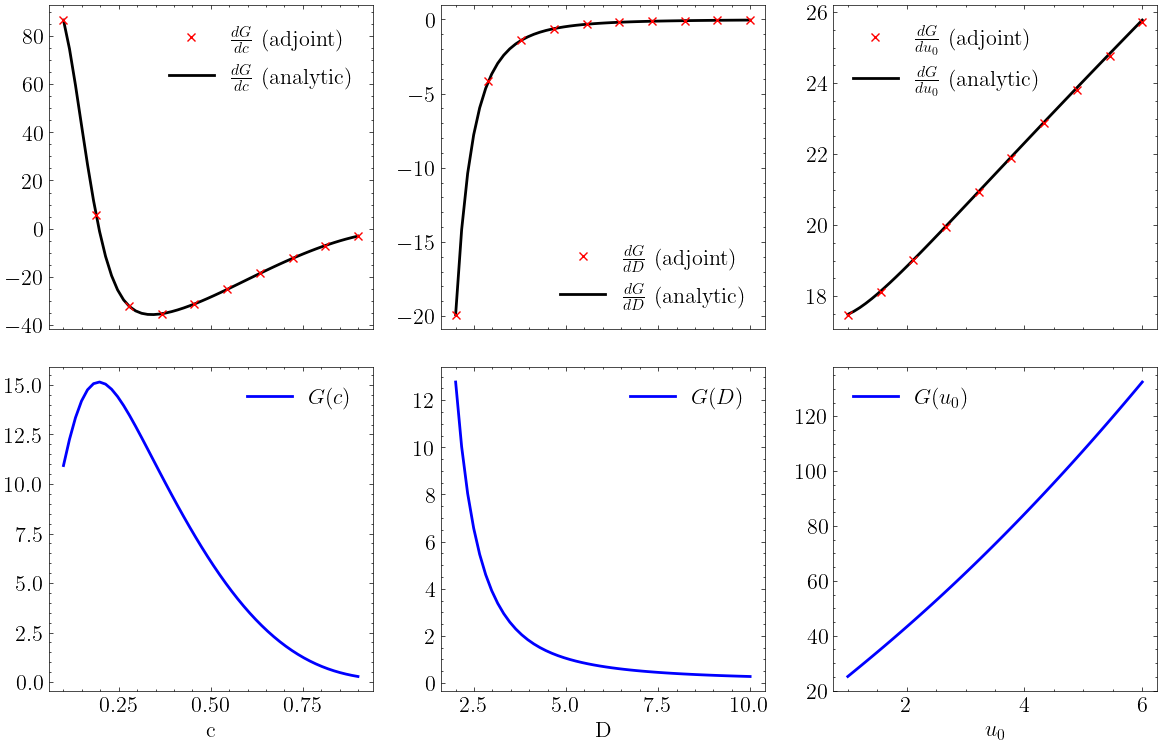

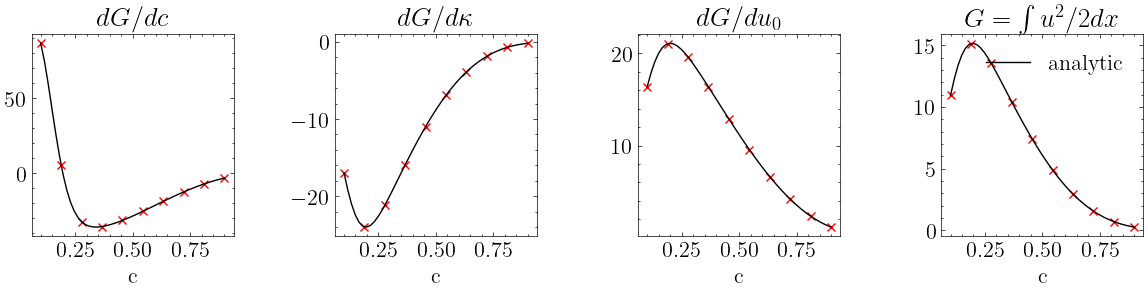

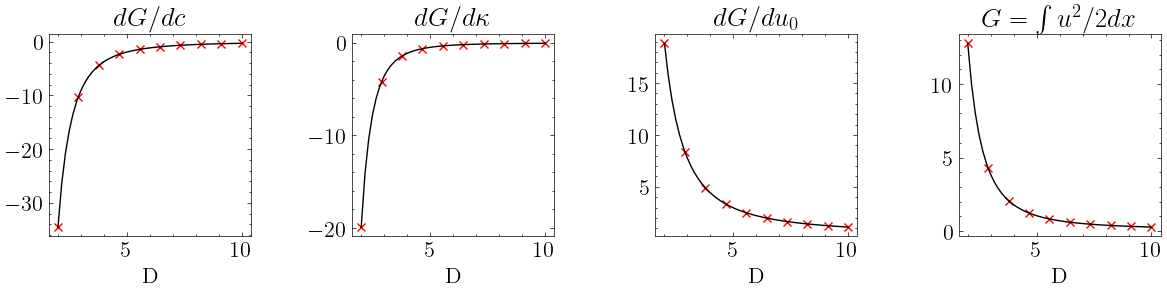

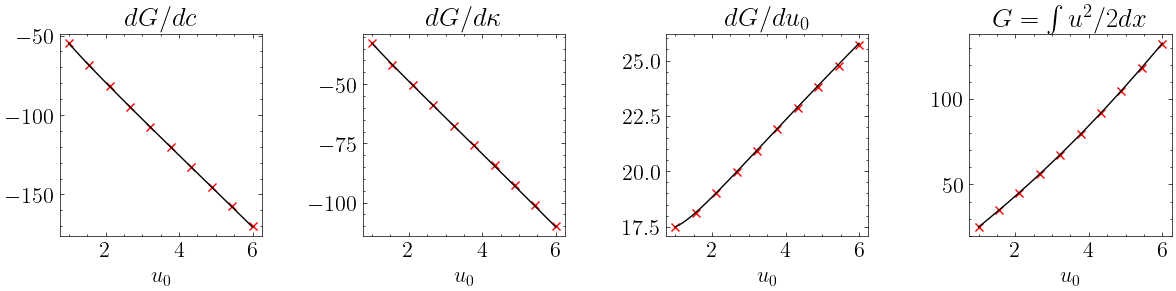

In [8]:
c = 0.3
D = 2.0
u0s = jnp.linspace(1.0,6.0,10)
G_comp = []
g_c_an = []
g_kappa_an = []
g_u0_an = []
fig,ax=plt.subplots(1,4)
for u0 in list(u0s):
    config = toml.load(config_file)
    config["AdjointTestProblem"]["SourceCentre"] = float(c)
    config["AdjointTestProblem"]["kappa"] = float(D)
    config["AutodiffTransportSystem"]["InitialHeights"] = [float(u0)]
    config["AutodiffTransportSystem"]["uR"] = [float(u0)]
    
    with open(config_file,"w") as f:
        s = toml.dump(config,f)
    run_manta(config_file)
    data = Dataset("AdjointTestProblem.nc","r")
    p2 = np.array(data.groups["G_boundary"].variables["p0"])
    p1 = np.array(data.groups["G_p"].variables["p1"])
    p0 = np.array(data.groups["G_p"].variables["p0"])
    G0 = np.array(data.variables["GFn"])
    data.close()

    ax[0].plot(u0,p0,'rx')
    ax[1].plot(u0,p1,"rx")
    ax[2].plot(u0,p2,"rx")
    ln, = ax2[0,2].plot(u0,p2,"rx",linewidth=2.0)
    ax[3].plot(u0,G0,'rx')
    
ln.set_label(r"$\frac{dG}{du_0}$ (adjoint)")
u0s = jnp.linspace(1.0,6.0,50)
for u0 in u0s:
    grad_c, grad_kappa, grad_u0 = gradp(c, D, u0)
    
    g_c_an.append(grad_c)
    g_kappa_an.append(grad_kappa)
    g_u0_an.append(grad_u0)
    G_comp.append(g(c,D,u0))

ax[0].plot(u0s,g_c_an,'k')
ax[1].plot(u0s,g_kappa_an,'k')
ax[2].plot(u0s,g_u0_an,'k')
ax2[0,2].plot(u0s,g_u0_an,'k',label=r"$\frac{dG}{du_0}$ (analytic)",linewidth=2.0,zorder=-1)
ax[3].plot(u0s,G_comp,'k')

ax[0].set_title(r"$dG/dc$")
ax[1].set_title(r"$dG/d\kappa$")
ax[2].set_title(r"$dG/du_0$")
ax[3].set_title(r"$G = \int u^2/2 dx$")

ax3 = ax2[1,2]
ax3.plot(u0s,G_comp,label=r"$G(u_0)$",color=ycolor,linewidth=2.0)
#ax3.set_ylabel('G',color=ycolor)
#ax3.tick_params(axis='y', labelcolor=ycolor)

ax[0].set_xlabel(r"$u_0$")
ax[1].set_xlabel(r"$u_0$")
ax[2].set_xlabel(r"$u_0$")
ax[3].set_xlabel(r"$u_0$")
ax2[1,2].set_xlabel(r"$u_0$")
ax[3].legend()

for a in ax:
    a.set_box_aspect(1)

    
for a in ax2.flatten():
    a.set_box_aspect(1)
    a.legend()


fig.set_figwidth(15)
fig2.set_figwidth(12)
fig2.set_figheight(8)
fig2.tight_layout()
plt.show()
